In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import time
from joblib import Parallel, delayed

In [18]:
processed_data_path = './data/processed/processed_data.csv'
company_lookup_path = './data/processed/company_lookup.csv'

processed_data = pd.read_csv(processed_data_path)
company_lookup = pd.read_csv(company_lookup_path)

In [19]:
company_lookup.sort_values(by='Ticker_Encoded', inplace=True)
company_lookup.reset_index(drop=True, inplace=True)
company_lookup.head()

,Brand_Name,Ticker,Industry_Tag,Ticker_Encoded,Industry_Tag_Encoded
0,apple,AAPL,technology,0,22
1,airbnb,ABNB,hospitality,1,15
2,adobe,ADBE,technology,2,22
3,adidas,ADDYY,apparel,3,0
4,american eagle outfitters,AEO,apparel,4,0


In [166]:
seq_len = 60

In [167]:
def split_train_test_by_stock(df, test_size=0.2):
    train_parts = []
    test_parts = []

    grouped = df.groupby('Ticker_Encoded')

    for _, group in grouped:
        group = group.sort_values(by='Date')  # Ensure chronological order
        n = len(group)
        split_idx = int(n * (1 - test_size))

        train_parts.append(group.iloc[:split_idx])
        test_parts.append(group.iloc[split_idx:])

    train_df = pd.concat(train_parts).reset_index(drop=True)
    test_df = pd.concat(test_parts).reset_index(drop=True)

    return train_df, test_df

In [168]:
train_df, test_df = split_train_test_by_stock(processed_data, test_size=0.2)

In [169]:
class StockDataset(Dataset):
    def __init__(self, df, seq_len=30):
        self.data = df

        self.seq_len = seq_len

        grouped_data = self.data.groupby('Ticker_Encoded')

        def makeSamplePerGroup(group, seq_len):
            group = group.sort_values(by='Date').reset_index(drop=True)
            sample = []
            for i in range(len(group) - seq_len):
                seq = group.iloc[i:i + seq_len]
                target = group.iloc[i + seq_len][['open_normalized', 'high_normalized', 'low_normalized', 'close_normalized', 'volume_normalized']]

                features = seq[['open_normalized', 'high_normalized', 'low_normalized', 'close_normalized', 'volume_normalized']].values
                stock_id = group.iloc[i]['Ticker_Encoded']
                industry_id = group.iloc[i]['Industry_Tag_Encoded']

                sample.append({
                    'features': torch.tensor(features, dtype=torch.float32),
                    'target': torch.tensor(target, dtype=torch.float32),
                    'stock_id': torch.tensor(stock_id, dtype=torch.long),
                    'industry_id': torch.tensor(industry_id, dtype=torch.long),
                })

            return sample
        
        all_samples = Parallel(n_jobs=-1)(
            delayed(makeSamplePerGroup)(group, seq_len) for _, group in grouped_data
        )

        self.samples = [item for sublist in all_samples for item in sublist]
            

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        return sample



In [170]:
class StockLSTM(nn.Module):
    def __init__(self, num_stocks, num_industries, input_size=5, hidden_size=64, num_layers=2, stock_emb_dim=16, industry_emb_dim=16):
        super().__init__()
        
        self.stock_embedding = nn.Embedding(num_stocks, stock_emb_dim)
        self.industry_embedding = nn.Embedding(num_industries, industry_emb_dim)

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + stock_emb_dim + industry_emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

    def forward(self, x, stock_id, industry_id):
        stock_emb = self.stock_embedding(stock_id)
        industry_emb = self.industry_embedding(industry_id)

        _, (hidden, _) = self.lstm(x)
        lstm_out = hidden[-1]  

        combined = torch.cat([lstm_out, stock_emb, industry_emb], dim=1)
        out = self.fc(combined)

        return out
        

In [171]:
train_dataset = StockDataset(train_df, seq_len)
test_dataset = StockDataset(test_df, seq_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = StockLSTM(
    num_stocks=len(processed_data['Ticker_Encoded'].unique()), 
    num_industries=len(processed_data['Industry_Tag_Encoded'].unique())
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [172]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    print("Training started on device:", device)
    for epoch in range(epochs):
        start = time.time()
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            
            features = batch['features'].to(device)
            target = batch['target'].to(device)
            stock_id = batch['stock_id'].to(device)
            industry_id = batch['industry_id'].to(device)

            optimizer.zero_grad()
            outputs = model(features, stock_id, industry_id)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.detach().item()
        end = time.time()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Time: {end - start:.2f}s")

In [173]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            features = batch['features'].to(device)
            target = batch['target'].to(device)
            stock_id = batch['stock_id'].to(device)
            industry_id = batch['industry_id'].to(device)

            outputs = model(features, stock_id, industry_id)
            loss = criterion(outputs, target)
            total_loss += loss.detach().item()
    
    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.6f}")


In [174]:
train_model(model, train_loader, criterion, optimizer, device, epochs=10)

Training started on device: cuda
Epoch 1/10, Loss: 4.997330499961579e-05, Time: 14.03s
Epoch 2/10, Loss: 1.0555761081851372e-05, Time: 13.42s
Epoch 3/10, Loss: 8.322038979106595e-06, Time: 13.29s
Epoch 4/10, Loss: 7.908243104708145e-06, Time: 13.24s
Epoch 5/10, Loss: 7.636698223865767e-06, Time: 13.26s
Epoch 6/10, Loss: 7.3904031851736845e-06, Time: 13.22s
Epoch 7/10, Loss: 7.188994239014814e-06, Time: 13.23s
Epoch 8/10, Loss: 7.089170983970401e-06, Time: 13.24s
Epoch 9/10, Loss: 7.043156986728545e-06, Time: 13.33s
Epoch 10/10, Loss: 6.766049761089732e-06, Time: 13.25s


In [175]:
evaluate_model(model, test_loader, criterion, device)

Test Loss: 0.000053


In [176]:
close_min = processed_data['Close'].min()
close_max = processed_data['Close'].max()

open_min = processed_data['Open'].min()
open_max = processed_data['Open'].max()

high_min = processed_data['High'].min()
high_max = processed_data['High'].max()

low_min = processed_data['Low'].min()
low_max = processed_data['Low'].max()

volume_min = processed_data['Volume'].min()
volume_max = processed_data['Volume'].max()   

In [177]:
def denormalize(x, x_min, x_max):
    return x * (x_max - x_min) + x_min

In [178]:
model.eval()
for i in range(5):
    sample = test_dataset[i]
    features = sample['features'].unsqueeze(0).to(device)
    stock_id = sample['stock_id'].unsqueeze(0).to(device)
    industry_id = sample['industry_id'].unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(features, stock_id, industry_id).squeeze(0)[3].item()  # Extract the last value (e.g., closing price)
        actual = sample['target'][3].item()  # Extract the last value (e.g., closing price) from the target
        print(f"Sample {i+1}: Predicted: ${denormalize(prediction, close_min, close_max):.2f}, Actual: ${denormalize(actual, close_min, close_max):.2f}")

Sample 1: Predicted: $95.05, Actual: $110.73
Sample 2: Predicted: $96.37, Actual: $107.43
Sample 3: Predicted: $93.68, Actual: $111.00
Sample 4: Predicted: $96.11, Actual: $112.97
Sample 5: Predicted: $98.68, Actual: $112.87


## Evaluate Model

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

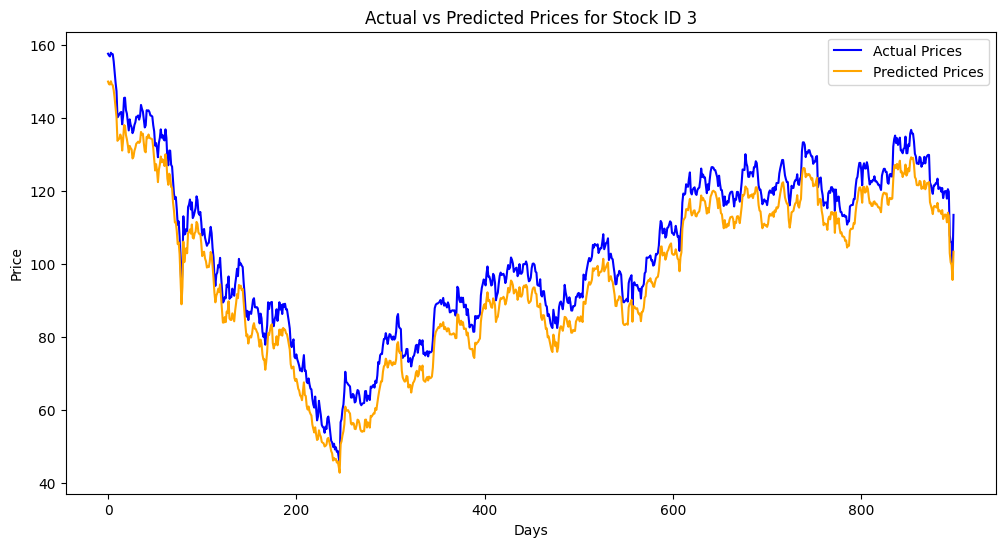

In [180]:
# Extract data for the specific stock from test data
specific_stock_data = test_df[test_df['Ticker_Encoded'] == 3]

# Prepare the data for prediction
# seq_len = 30
predicted_prices = []
actual_prices = []

for i in range(len(specific_stock_data) - seq_len):
    seq = specific_stock_data.iloc[i:i + seq_len]
    features = seq[['open_normalized', 'high_normalized', 'low_normalized', 'close_normalized', 'volume_normalized']].values
    features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(device)

    stock_id_tensor = torch.tensor([3], dtype=torch.long).to(device)
    industry_id_tensor = torch.tensor([seq['Industry_Tag_Encoded'].iloc[0]], dtype=torch.long).to(device)

    with torch.no_grad():
        prediction = model(features_tensor, stock_id_tensor, industry_id_tensor).squeeze(0)[3].item()  # Extract the closing price (index 3)
        predicted_prices.append(denormalize(prediction, close_min, close_max))

    actual_prices.append(denormalize(seq['close_normalized'].iloc[-1], close_min, close_max))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_prices)), actual_prices, label='Actual Prices', color='blue')
plt.plot(range(len(predicted_prices)), predicted_prices, label='Predicted Prices', color='orange')
plt.title(f"Actual vs Predicted Prices for Stock ID {3}")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

## Test model against new data

In [191]:
#retrive new stock data from yfinance
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [192]:
def customScale(x, x_min, x_max):
    x_normalized = (x - x_min) / (x_max - x_min)
    return x_normalized

In [193]:
ticker_id = company_lookup.sample(1)['Ticker'].values[0]
company_name = company_lookup[company_lookup['Ticker'] == ticker_id]['Brand_Name'].values[0]

ticker = yf.Ticker(ticker_id)

historical_data = ticker.history(period='1y', interval='1d')
historical_data.reset_index(inplace=True)
historical_data = historical_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].reset_index(drop=True)
historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date

historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date
historical_data['Ticker_Encoded'] = company_lookup[company_lookup['Ticker'] == ticker_id]['Ticker_Encoded'].values[0]
historical_data['Industry_Tag_Encoded'] = company_lookup[company_lookup['Ticker'] == ticker_id]['Industry_Tag_Encoded'].values[0]

historical_data['open_normalized'] = customScale(historical_data['Open'], open_min, open_max)
historical_data['high_normalized'] = customScale(historical_data['High'], high_min, high_max)
historical_data['low_normalized'] = customScale(historical_data['Low'], low_min, low_max)
historical_data['close_normalized'] = customScale(historical_data['Close'], close_min, close_max)
historical_data['volume_normalized'] = customScale(historical_data['Volume'], volume_min, volume_max)

print(ticker_id)
print(historical_data.head())

DIS
         Date        Open        High         Low       Close   Volume  \
0  2024-04-18  112.163245  113.223633  111.182141  111.419983  8235600   
1  2024-04-19  110.716362  111.707378  110.082112  111.598366  9407800   
2  2024-04-22  112.083961  112.619111  110.746091  110.983932  6901700   
3  2024-04-23  111.816385  113.213714  111.786656  112.688477  6839300   
4  2024-04-24  112.123600  113.154258  112.123600  112.896591  6157200   

   Ticker_Encoded  Industry_Tag_Encoded  open_normalized  high_normalized  \
0              17                     6         0.032498         0.032639   
1              17                     6         0.032078         0.032201   
2              17                     6         0.032474         0.032464   
3              17                     6         0.032397         0.032636   
4              17                     6         0.032486         0.032619   

   low_normalized  close_normalized  volume_normalized  
0        0.032936          0.03

In [194]:
def makeSamplePerGroup(group, seq_len):
            group = group.sort_values(by='Date').reset_index(drop=True)
            sample = []
            for i in range(len(group) - seq_len):
                seq = group.iloc[i:i + seq_len]
                target = group.iloc[i + seq_len][['open_normalized', 'high_normalized', 'low_normalized', 'close_normalized', 'volume_normalized']]

                features = seq[['open_normalized', 'high_normalized', 'low_normalized', 'close_normalized', 'volume_normalized']].values
                stock_id = group.iloc[i]['Ticker_Encoded']
                industry_id = group.iloc[i]['Industry_Tag_Encoded']

                sample.append({
                    'features': torch.tensor(features, dtype=torch.float32),
                    'target': torch.tensor(target, dtype=torch.float32),
                    'stock_id': torch.tensor(stock_id, dtype=torch.long),
                    'industry_id': torch.tensor(industry_id, dtype=torch.long),
                })

            return sample

In [195]:
targets = historical_data['close_normalized'].values[-(len(historical_data) - seq_len):]

samples = makeSamplePerGroup(historical_data, seq_len)

predictions = []
model.eval()
with torch.no_grad():
    for sample in samples:
        features = sample['features'].unsqueeze(0).to(device)
        stock_id = sample['stock_id'].unsqueeze(0).to(device)
        industry_id = sample['industry_id'].unsqueeze(0).to(device)
        prediction = model(features, stock_id, industry_id).squeeze(0)[3].item()  # Extract the closing price (index 3)
        predictions.append(prediction)

# Denormalize predictions
denormalized_predictions = [denormalize(pred, close_min, close_max) for pred in predictions]

C:\Users\User\AppData\Local\Temp\ipykernel_10632\4086067797.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'target': torch.tensor(target, dtype=torch.float32),
C:\Users\User\AppData\Local\Temp\ipykernel_10632\4086067797.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'target': torch.tensor(target, dtype=torch.float32),
C:\Users\User\AppData\Local\Temp\ipykernel_10632\4086067797.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

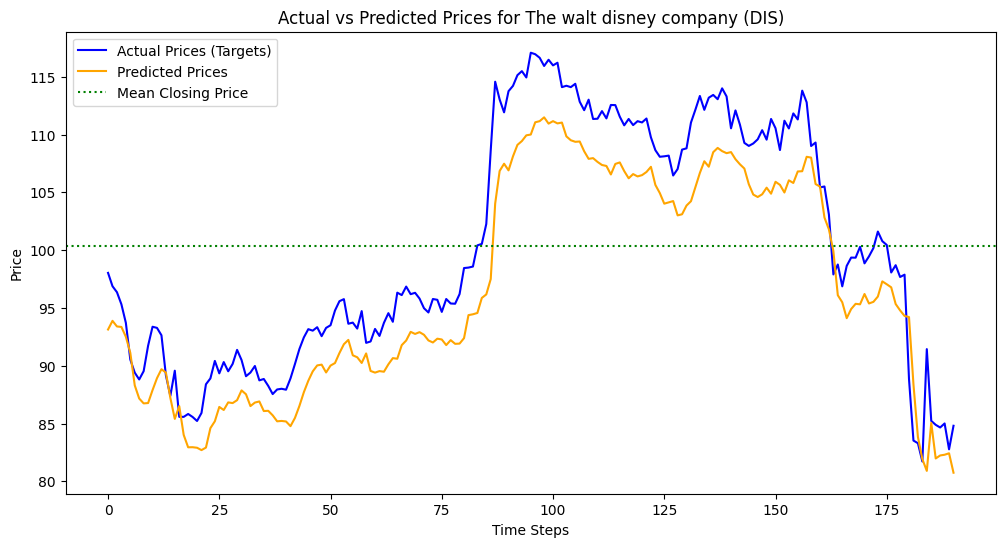

In [196]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(targets)), [denormalize(t, close_min, close_max) for t in targets], label='Actual Prices (Targets)', color='blue')
plt.plot(range(len(predictions)), [denormalize(p, close_min, close_max) for p in predictions], label='Predicted Prices', color='orange')
mean_price = np.mean([denormalize(t, close_min, close_max) for t in targets])
plt.axhline(y=mean_price, color='green', linestyle='dotted', label='Mean Closing Price')
plt.title(f"Actual vs Predicted Prices for {company_name.capitalize()} ({ticker_id})")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()

### Save the model and important variables

In [197]:
torch.save(model.state_dict(), './models/stock_lstm_model.pth')

In [198]:
import pickle

# Define the variables to save
important_variables = {
    'close_min': close_min,
    'close_max': close_max,
    'open_min': open_min,
    'open_max': open_max,
    'high_min': high_min,
    'high_max': high_max,
    'low_min': low_min,
    'low_max': low_max,
    'volume_min': volume_min,
    'volume_max': volume_max,
    'seq_len': seq_len,
    'num_stocks': len(processed_data['Ticker_Encoded'].unique()),
    'num_industries': len(processed_data['Industry_Tag_Encoded'].unique()),
}

# Save the variables to a file
with open('./models/important_variables.pkl', 'wb') as f:
    pickle.dump(important_variables, f)

### Test that model and variables saved correctly

In [199]:
# Load the saved variables
with open('./models/important_variables.pkl', 'rb') as f:
    loaded_variables = pickle.load(f)

# # Verify the loaded variables
# for key in important_variables:
#     assert important_variables[key] == loaded_variables[key], f"Mismatch in variable: {key}"

# Load the saved model
loaded_model = StockLSTM(
    num_stocks=loaded_variables['num_stocks'], 
    num_industries=loaded_variables['num_industries']
)
loaded_model.load_state_dict(torch.load('./models/stock_lstm_model.pth'))
loaded_model.to(device)
loaded_model.eval()

print("Model and variables loaded successfully and verified.")

Model and variables loaded successfully and verified.


### Test loaded model

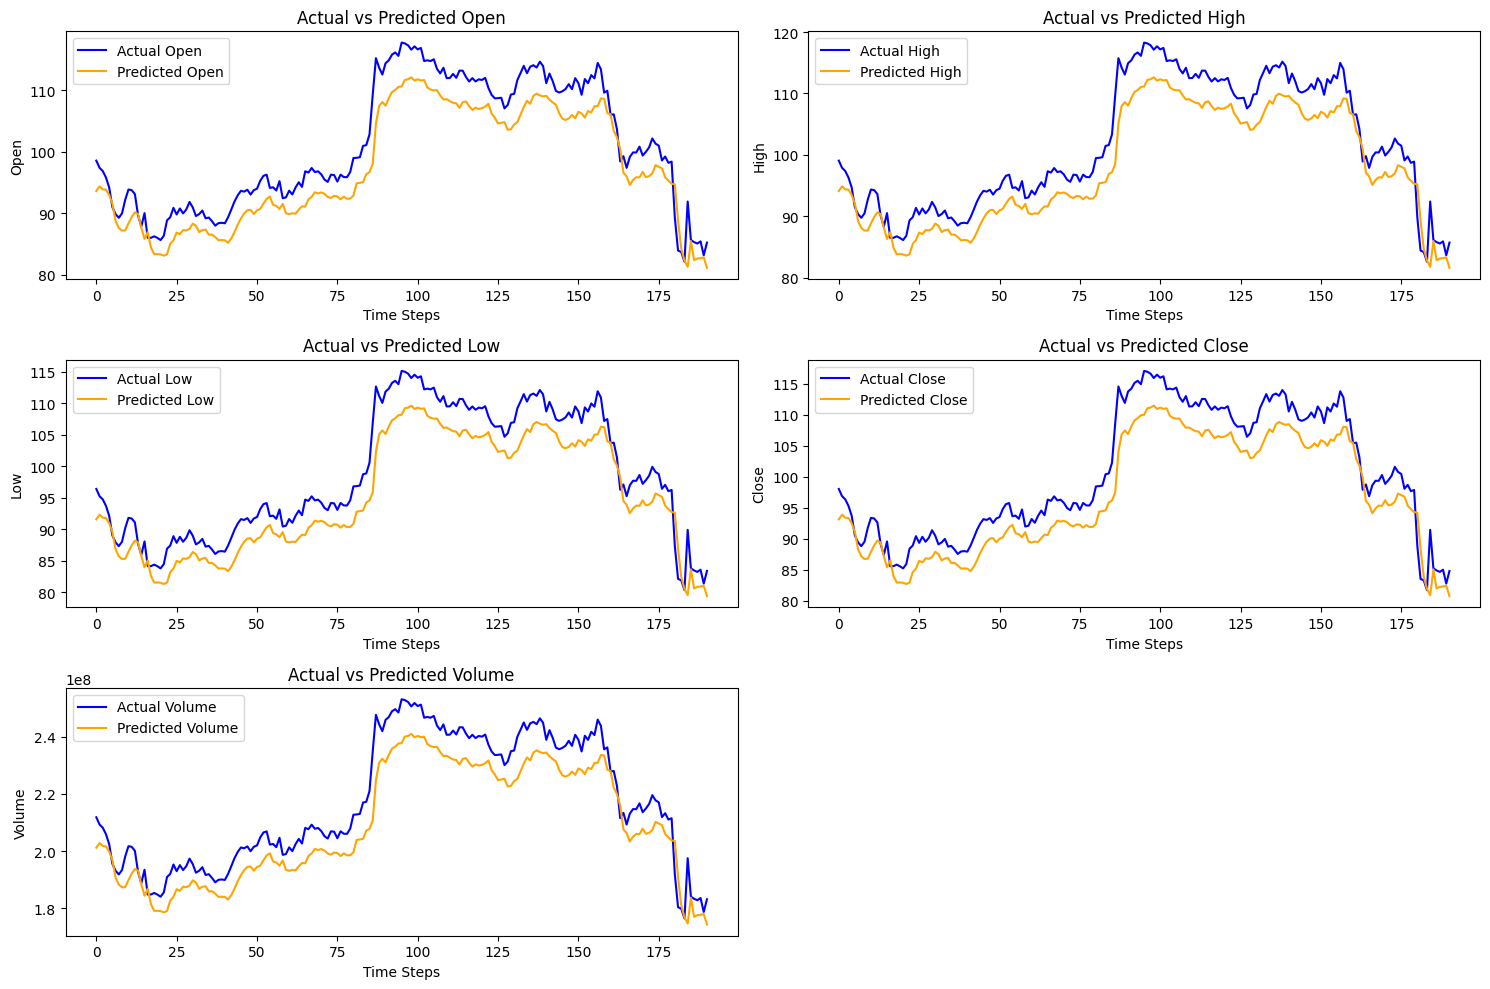

In [200]:
# Extract predicted and actual values for all 5 features
predicted_values = np.array(predictions)
actual_values = np.array(targets)

# Denormalize the values for plotting
denormalized_predicted = np.array([denormalize(predicted_values, eval(f"{col}_min"), eval(f"{col}_max")) for col in ['open', 'high', 'low', 'close', 'volume']])
denormalized_actual = np.array([denormalize(actual_values, eval(f"{col}_min"), eval(f"{col}_max")) for col in ['open', 'high', 'low', 'close', 'volume']])

# Plot the results
plt.figure(figsize=(15, 10))
labels = ['Open', 'High', 'Low', 'Close', 'Volume']
for i in range(5):
    plt.subplot(3, 2, i + 1)
    plt.plot(denormalized_actual[i], label=f'Actual {labels[i]}', color='blue')
    plt.plot(denormalized_predicted[i], label=f'Predicted {labels[i]}', color='orange')
    plt.title(f'Actual vs Predicted {labels[i]}')
    plt.xlabel('Time Steps')
    plt.ylabel(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()